In [8]:
import torch
import clip
import time
import shutil
import math
import random

import numpy as np
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets

import torch.nn as nn
import torch.optim as optim
import torch.utils.data


torch.cuda.is_available()


start_epoch = 0
epochs = 200
batch_size = 32
LR = 1e-4
print_frequency = 10


class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(dim, 128)
        self.BN1 = nn.BatchNorm1d(128)
        self.out = nn.Linear(128, 2)
        self.BN2 = nn.BatchNorm1d(2)
        
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.BN1(self.hidden1(x))
        x = F.relu(x)
        x = self.BN2(self.out(x))
        return x

class myMoCo(nn.Module):
    def __init__(self):
        super(myMoCo, self).__init__()
        
        self.pos = 4 #the number of positive samples
        
        self.indim = 512
        self.outdim = 2
        self.m = 0.999
        self.T = 0.1
        self.K = 128
        
        self.mlp_q = MLP(self.indim).cuda()
        self.mlp_k = MLP(self.indim).cuda()
        for param_q, param_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            param_k.data.copy_(param_q.data) #initialize key MLP
            param_k.required_grad = False
        
        self.register_buffer("queue", torch.randn(self.outdim, self.K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))   
        
    """
    input_q : Batch x feat_size == N x inDim
    input_k : (Batch x pos_pairs) x feat_size == (N x J) x inDim ==> M x inDim
    """ 
    def forward(self, pos_pairs):
        input_q = pos_pairs[:,:1,:] #N x 1  x inDim
        input_q = input_q.squeeze() #N x inDim
        input_q = nn.functional.normalize(input_q, dim=1)
        
        q = self.mlp_q(input_q) # N x outDim
        q = nn.functional.normalize(q, dim=1)
        
        with torch.no_grad():
            input_k = pos_pairs[:,1:,:] #N x J x inDim
            N = input_k.shape[0]
            J = input_k.shape[1]
            input_k = torch.reshape(input_k, (-1, self.indim)) # reshape : (N x J) x inDim ==> M x inDim
            input_k = nn.functional.normalize(input_k, dim=1)
            
            k = self.mlp_k(input_k) # M x outDim
            k = nn.functional.normalize(k, dim=1)
            
            k = torch.reshape(k, (N, -1, self.outdim)) # undo reshape : M x outDim ==>(N x J) x outDim
        
        loss_pos = torch.einsum("nc,njc->nj", [q, k]).unsqueeze(-1) # N x J
        loss_neg = torch.einsum("nc,ck->nk", [q, self.queue.clone().detach()]) # N x K
        
        logits1 = torch.cat([loss_pos[:, 0], loss_neg], dim=1) # N x (1+K)
        logits2 = torch.cat([loss_pos[:, 1], loss_neg], dim=1)
        logits3 = torch.cat([loss_pos[:, 2], loss_neg], dim=1)
        
        logits1 /= self.T
        logits2 /= self.T
        logits3 /= self.T
        
        labels = torch.zeros(logits1.shape[0], dtype=torch.long).cuda()
        
        self._dequeue_and_enqueue(k)
        
        return logits1, logits2, logits3, labels
    
    
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            param_k.data = param_k.data*self.m + param_q.data*(1.0-self.m)
        
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        chosen = random.randint(0, self.pos-2)
        k = keys[:, chosen, :].squeeze() #chose one view: N x J x C ==> N x 1 x C ==> N x C
        M = keys.shape[0]
        ptr = int(self.queue_ptr)
        self.queue[:, ptr : ptr + M] = k.T
        ptr = (ptr + M) % self.K
        self.queue_ptr[0] = ptr

def adjust_learning_rate(optimizer, epoch):
    lr = LR
    lr *= 0.5 * (1.0 + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def save_checkpoint(state, is_best, filename):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "model_best.pth.tar")


def train(train_loader, model, criterion, optimizer, epoch):
    for i, pos_pairs in enumerate(train_loader):
        
        output1, output2, output3, target = model(pos_pairs)
        
        loss = (criterion(output1, target) + criterion(output2, target) + criterion(output3, target))/3
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

        print('Epoch[{0}]    Iter[{1}/8]    Loss: {2}'.format(epoch+1, i+1, loss))
        

def main():
    
    model = myMoCo().cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(
        model.parameters(), 
        lr = LR,
        momentum = 0.9,
        weight_decay = 1e-4
    )
    
    """
    # optionally resume from a checkpoint
    ...
    """
    
    cudnn.benchmark = True
    
    train_file = '../CUHK01/dataset.pkl'
    N = 256
    B = 32
    
    train_dataset = torch.load(train_file).cuda()
    train_dataset = train_dataset[:N]
    
    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = B,
        shuffle = True
    )
    
    for epoch in range(start_epoch, epochs):
        
        adjust_learning_rate(optimizer, epoch)
        train(trainloader, model, criterion, optimizer, epoch)
        
        print('\n\n')
        
        torch.save(model.mlp_q.state_dict(), './pretrained/MLP/mlp{:04d}.pth.tar'.format(epoch+1))
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            },
            is_best=False,
            filename="./pretrained/myMoCo/checkpoint_{:04d}.pth.tar".format(epoch+1),
        )


In [9]:
main()
print('DONE!')

Epoch[1]    Iter[1/8]    Loss: 9.991118431091309
Epoch[1]    Iter[2/8]    Loss: 10.511457443237305
Epoch[1]    Iter[3/8]    Loss: 11.92044448852539
Epoch[1]    Iter[4/8]    Loss: 10.713165283203125
Epoch[1]    Iter[5/8]    Loss: 10.548739433288574
Epoch[1]    Iter[6/8]    Loss: 10.622894287109375
Epoch[1]    Iter[7/8]    Loss: 10.914606094360352
Epoch[1]    Iter[8/8]    Loss: 9.618871688842773



Epoch[2]    Iter[1/8]    Loss: 9.94316291809082
Epoch[2]    Iter[2/8]    Loss: 11.538795471191406
Epoch[2]    Iter[3/8]    Loss: 10.113571166992188
Epoch[2]    Iter[4/8]    Loss: 10.142252922058105
Epoch[2]    Iter[5/8]    Loss: 10.412479400634766
Epoch[2]    Iter[6/8]    Loss: 10.264566421508789
Epoch[2]    Iter[7/8]    Loss: 10.513701438903809
Epoch[2]    Iter[8/8]    Loss: 8.821983337402344



Epoch[3]    Iter[1/8]    Loss: 9.462642669677734
Epoch[3]    Iter[2/8]    Loss: 9.963282585144043
Epoch[3]    Iter[3/8]    Loss: 9.760221481323242
Epoch[3]    Iter[4/8]    Loss: 9.754337310791016
Epoc

Epoch[27]    Iter[6/8]    Loss: 9.060791015625
Epoch[27]    Iter[7/8]    Loss: 6.968593597412109
Epoch[27]    Iter[8/8]    Loss: 7.661090850830078



Epoch[28]    Iter[1/8]    Loss: 7.796133041381836
Epoch[28]    Iter[2/8]    Loss: 8.42970085144043
Epoch[28]    Iter[3/8]    Loss: 8.01995849609375
Epoch[28]    Iter[4/8]    Loss: 7.766955375671387
Epoch[28]    Iter[5/8]    Loss: 7.559291362762451
Epoch[28]    Iter[6/8]    Loss: 7.95703649520874
Epoch[28]    Iter[7/8]    Loss: 8.020480155944824
Epoch[28]    Iter[8/8]    Loss: 7.604938507080078



Epoch[29]    Iter[1/8]    Loss: 7.640697002410889
Epoch[29]    Iter[2/8]    Loss: 7.313472270965576
Epoch[29]    Iter[3/8]    Loss: 7.597537994384766
Epoch[29]    Iter[4/8]    Loss: 8.168588638305664
Epoch[29]    Iter[5/8]    Loss: 8.640737533569336
Epoch[29]    Iter[6/8]    Loss: 7.038112163543701
Epoch[29]    Iter[7/8]    Loss: 7.717587471008301
Epoch[29]    Iter[8/8]    Loss: 7.972430229187012



Epoch[30]    Iter[1/8]    Loss: 7.7149562835693

Epoch[52]    Iter[7/8]    Loss: 7.41110897064209
Epoch[52]    Iter[8/8]    Loss: 6.957221984863281



Epoch[53]    Iter[1/8]    Loss: 8.281370162963867
Epoch[53]    Iter[2/8]    Loss: 7.87462043762207
Epoch[53]    Iter[3/8]    Loss: 7.196188926696777
Epoch[53]    Iter[4/8]    Loss: 7.363827705383301
Epoch[53]    Iter[5/8]    Loss: 9.17972469329834
Epoch[53]    Iter[6/8]    Loss: 7.524663925170898
Epoch[53]    Iter[7/8]    Loss: 7.130013942718506
Epoch[53]    Iter[8/8]    Loss: 6.957482814788818



Epoch[54]    Iter[1/8]    Loss: 7.804722785949707
Epoch[54]    Iter[2/8]    Loss: 7.328888893127441
Epoch[54]    Iter[3/8]    Loss: 7.273114204406738
Epoch[54]    Iter[4/8]    Loss: 7.483338832855225
Epoch[54]    Iter[5/8]    Loss: 7.403128623962402
Epoch[54]    Iter[6/8]    Loss: 6.977447032928467
Epoch[54]    Iter[7/8]    Loss: 8.120990753173828
Epoch[54]    Iter[8/8]    Loss: 7.956133842468262



Epoch[55]    Iter[1/8]    Loss: 7.935293197631836
Epoch[55]    Iter[2/8]    Loss: 8.5912647247

Epoch[78]    Iter[1/8]    Loss: 7.938326835632324
Epoch[78]    Iter[2/8]    Loss: 7.476102352142334
Epoch[78]    Iter[3/8]    Loss: 7.712252616882324
Epoch[78]    Iter[4/8]    Loss: 7.298743724822998
Epoch[78]    Iter[5/8]    Loss: 6.857696533203125
Epoch[78]    Iter[6/8]    Loss: 8.185464859008789
Epoch[78]    Iter[7/8]    Loss: 7.775598526000977
Epoch[78]    Iter[8/8]    Loss: 6.704279899597168



Epoch[79]    Iter[1/8]    Loss: 7.49756383895874
Epoch[79]    Iter[2/8]    Loss: 7.093326568603516
Epoch[79]    Iter[3/8]    Loss: 6.7827887535095215
Epoch[79]    Iter[4/8]    Loss: 7.564272880554199
Epoch[79]    Iter[5/8]    Loss: 8.054963111877441
Epoch[79]    Iter[6/8]    Loss: 7.310515403747559
Epoch[79]    Iter[7/8]    Loss: 7.963703155517578
Epoch[79]    Iter[8/8]    Loss: 7.41586971282959



Epoch[80]    Iter[1/8]    Loss: 6.9381818771362305
Epoch[80]    Iter[2/8]    Loss: 7.335349082946777
Epoch[80]    Iter[3/8]    Loss: 7.381712913513184
Epoch[80]    Iter[4/8]    Loss: 7.3664488792

Epoch[103]    Iter[4/8]    Loss: 7.060758113861084
Epoch[103]    Iter[5/8]    Loss: 7.203439235687256
Epoch[103]    Iter[6/8]    Loss: 7.998546123504639
Epoch[103]    Iter[7/8]    Loss: 7.363735198974609
Epoch[103]    Iter[8/8]    Loss: 7.122287750244141



Epoch[104]    Iter[1/8]    Loss: 7.780257225036621
Epoch[104]    Iter[2/8]    Loss: 8.239429473876953
Epoch[104]    Iter[3/8]    Loss: 7.351864814758301
Epoch[104]    Iter[4/8]    Loss: 7.138787269592285
Epoch[104]    Iter[5/8]    Loss: 6.396596431732178
Epoch[104]    Iter[6/8]    Loss: 7.0066328048706055
Epoch[104]    Iter[7/8]    Loss: 7.580354690551758
Epoch[104]    Iter[8/8]    Loss: 8.676603317260742



Epoch[105]    Iter[1/8]    Loss: 7.7827372550964355
Epoch[105]    Iter[2/8]    Loss: 7.737399101257324
Epoch[105]    Iter[3/8]    Loss: 6.876267910003662
Epoch[105]    Iter[4/8]    Loss: 7.200985908508301
Epoch[105]    Iter[5/8]    Loss: 7.061379432678223
Epoch[105]    Iter[6/8]    Loss: 7.71791934967041
Epoch[105]    Iter[7/8] 

Epoch[128]    Iter[4/8]    Loss: 7.944092750549316
Epoch[128]    Iter[5/8]    Loss: 7.230264186859131
Epoch[128]    Iter[6/8]    Loss: 7.573122024536133
Epoch[128]    Iter[7/8]    Loss: 7.083239555358887
Epoch[128]    Iter[8/8]    Loss: 7.223513603210449



Epoch[129]    Iter[1/8]    Loss: 7.3573102951049805
Epoch[129]    Iter[2/8]    Loss: 7.190711975097656
Epoch[129]    Iter[3/8]    Loss: 7.257603645324707
Epoch[129]    Iter[4/8]    Loss: 7.5331830978393555
Epoch[129]    Iter[5/8]    Loss: 7.599357604980469
Epoch[129]    Iter[6/8]    Loss: 7.85800313949585
Epoch[129]    Iter[7/8]    Loss: 6.954036712646484
Epoch[129]    Iter[8/8]    Loss: 7.361721038818359



Epoch[130]    Iter[1/8]    Loss: 7.262240409851074
Epoch[130]    Iter[2/8]    Loss: 8.24760627746582
Epoch[130]    Iter[3/8]    Loss: 7.6077094078063965
Epoch[130]    Iter[4/8]    Loss: 8.14964485168457
Epoch[130]    Iter[5/8]    Loss: 6.8762664794921875
Epoch[130]    Iter[6/8]    Loss: 7.821595668792725
Epoch[130]    Iter[7/8] 

Epoch[152]    Iter[7/8]    Loss: 6.285387992858887
Epoch[152]    Iter[8/8]    Loss: 7.439002990722656



Epoch[153]    Iter[1/8]    Loss: 7.818572044372559
Epoch[153]    Iter[2/8]    Loss: 8.396834373474121
Epoch[153]    Iter[3/8]    Loss: 7.545255184173584
Epoch[153]    Iter[4/8]    Loss: 6.758563041687012
Epoch[153]    Iter[5/8]    Loss: 7.037181854248047
Epoch[153]    Iter[6/8]    Loss: 6.993456840515137
Epoch[153]    Iter[7/8]    Loss: 6.9255194664001465
Epoch[153]    Iter[8/8]    Loss: 8.28437614440918



Epoch[154]    Iter[1/8]    Loss: 7.267519950866699
Epoch[154]    Iter[2/8]    Loss: 7.766284942626953
Epoch[154]    Iter[3/8]    Loss: 7.620931625366211
Epoch[154]    Iter[4/8]    Loss: 7.846892833709717
Epoch[154]    Iter[5/8]    Loss: 7.529951095581055
Epoch[154]    Iter[6/8]    Loss: 7.28062629699707
Epoch[154]    Iter[7/8]    Loss: 7.049596786499023
Epoch[154]    Iter[8/8]    Loss: 7.478354454040527



Epoch[155]    Iter[1/8]    Loss: 8.064082145690918
Epoch[155]    Iter[2/8]

Epoch[178]    Iter[6/8]    Loss: 6.995598793029785
Epoch[178]    Iter[7/8]    Loss: 7.617919445037842
Epoch[178]    Iter[8/8]    Loss: 7.6454596519470215



Epoch[179]    Iter[1/8]    Loss: 7.757349967956543
Epoch[179]    Iter[2/8]    Loss: 7.346251964569092
Epoch[179]    Iter[3/8]    Loss: 6.97537899017334
Epoch[179]    Iter[4/8]    Loss: 8.02341079711914
Epoch[179]    Iter[5/8]    Loss: 7.16199254989624
Epoch[179]    Iter[6/8]    Loss: 6.92352294921875
Epoch[179]    Iter[7/8]    Loss: 7.9753851890563965
Epoch[179]    Iter[8/8]    Loss: 7.247008323669434



Epoch[180]    Iter[1/8]    Loss: 7.289462566375732
Epoch[180]    Iter[2/8]    Loss: 8.42949104309082
Epoch[180]    Iter[3/8]    Loss: 7.369592189788818
Epoch[180]    Iter[4/8]    Loss: 7.672818660736084
Epoch[180]    Iter[5/8]    Loss: 7.117661476135254
Epoch[180]    Iter[6/8]    Loss: 7.367378234863281
Epoch[180]    Iter[7/8]    Loss: 7.069563865661621
Epoch[180]    Iter[8/8]    Loss: 7.232156753540039



Epoch[181]    Iter[1/8]  

torch.Size([6, 4, 512])


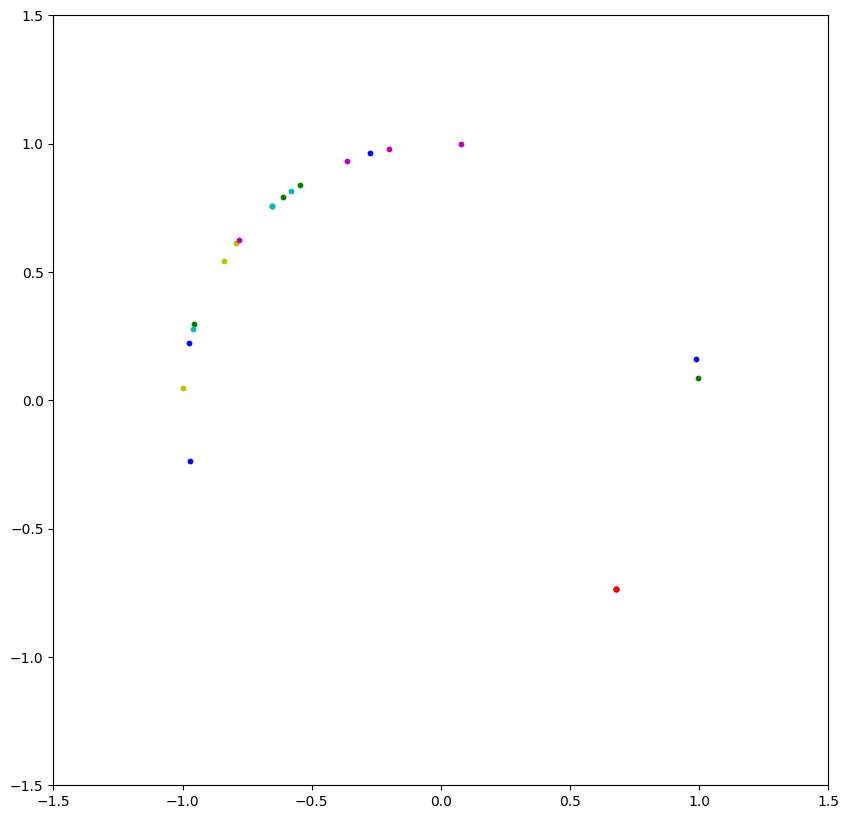

In [10]:
import matplotlib.pyplot as plt


def draw(x):

    color = ['r', 'y', 'g', 'b', 'm', 'c', 'k', 'w']
    ptr = 0
    
    fig = plt.figure(figsize=(10, 10))
    
    for pos in x:
        plt.scatter(pos.numpy()[:, 0], pos.numpy()[:, 1], c = color[ptr], s=10)
        ptr = (ptr+1)%len(color)
    
    plt.axis([-1.5, 1.5, -1.5, 1.5])
    plt.show()


weightdir = './pretrained/MLP/mlp0100.pth.tar'
weight = torch.load(weightdir)

mlp = MLP(512).cuda()
mlp.load_state_dict(weight)


path = '../CUHK01/dataset.pkl'
train_dataset = torch.load(path).cuda()

st = 0
end = 5
N = end-st+1
show_data = train_dataset[st:end+1]
inDim = show_data.shape[2]
print(show_data.shape)

inputs = show_data.reshape(-1, inDim)
outputs = mlp(inputs)
outputs = nn.functional.normalize(outputs, dim=1)
outputs = outputs.cpu().detach()

outDim = outputs.shape[1]
outputs = outputs.reshape(N, -1, outDim)
outputs.shape, outputs


draw(outputs)